In [292]:
import gensim
import warnings
warnings.filterwarnings('ignore')

# Setup nltk corpora path and Pubmed Word2Vec location
pubmed_vec_file = '/Users/timrand/nltk_data/corpora/PubMed-w2v.bin'

In [225]:
model = gensim.models.KeyedVectors.load_word2vec_format(pubmed_vec_file, binary=True)

In [226]:
#given the PubMed-w2v model, we can search for words the most similar to a given word. 
#Interestingly, for molecules, the assocaited words are other molecules
#These proteins/genes are in the same pathway. This is because molecule names are rarely used, 
#but when they are they are in association with each other. Therefore, they have high
#probability of being used near each other and nowhere else--thus a thigh w2v probability. 

TP53_assoc = model.most_similar('TP53', topn=20)
TP53_assoc[0:10]

/Users/timrand/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('k-ras', 0.8571987748146057),
 ('CDKN2A', 0.8442618250846863),
 ('KRAS2', 0.8374961614608765),
 ('K-RAS', 0.8317775130271912),
 ('RB1', 0.827904224395752),
 ('Tp53', 0.8247050046920776),
 ('KRAS', 0.8244420289993286),
 ('PIK3CA', 0.82399982213974),
 ('K-ras', 0.8214455842971802),
 ('CTNNB1', 0.8166534900665283)]

In [227]:
#just collect the gene names from the TP_53 list
TP53_assoc = [x[0] for x in TP53_assoc]
TP53_assoc

['k-ras',
 'CDKN2A',
 'KRAS2',
 'K-RAS',
 'RB1',
 'Tp53',
 'KRAS',
 'PIK3CA',
 'K-ras',
 'CTNNB1',
 'FBXW7',
 'CDKN2A/p16',
 'BRAF',
 'HRAS',
 'ARID1A',
 'DPC4',
 'IDH1/IDH2',
 'p16/CDKN2A',
 'CDKN2',
 'CDH1']

#### Make a dictionary of this pickle and re-pickle (better version)

In [228]:
import pickle
nomenclature_approved = pickle.load( open( "pickles/nomenclature_approved.pkl", "rb" ) )

#this should be changed to a dictionary for easier lookup
nom_dict = {}
for i,gene in enumerate(nomenclature_approved):
    try:
        nom_dict[gene[0]] = gene[1]
    except:
        print(f'failed on {gene} {i}')

#pickle.dump( nom_dict, open( "nomenclature_approved_dict.pkl", "wb" ) )
print(nom_dict['A2ML1-AS2'])

nomen = pickle.load( open( "nomenclature_approved_dict.pkl", "rb" ) )

failed on {} 56274
1


****
#### The following function sorts gene names according to lookup result, attempts to rescue gene names by dehyphenating and removing the '/' character often used to designate alternative names.

In [229]:
def bin_approve_fail_notFound(genes):
    """
    bin_fail_notFound() takes a gene string or list of genes and returns the names
    binned into lists in the following order: approve, failed, not found.
    """
    nomen_dict = pickle.load( open( "nomenclature_approved_dict.pkl", "rb" ) )
    
    approved = []
    failed = []
    no_entry = []
    
    #allow single gene lookup as str
    if type(genes) == str:
        genes = [genes]
    
    #include original, dehyphenated, '/'-split versions for lookup
    gene_cleaned=[]
    for _gene in genes:
        _gene = _gene.upper()           #everything in approved list is uppercase
        gene = _gene.replace('-','')   #no hyphens in approved list
        gene = gene.split('/')
        gene_cleaned = gene_cleaned + gene + [_gene]  #process original, dehyphenated-split 
    
    #Should we try to rescue genes with synonym lookup?
    #gene_cleaned + synonym list?
    
    #sort the gene according to lookup result
    for gene in gene_cleaned:
        try:
            approval_status = nomen_dict[gene]
            if approval_status == 1:
                approved.append(gene)
            else:
                failed.append(gene)
        except:
            no_entry.append(gene)
    
    #remove redundancies with set on each list
    approved = list(set(approved))
    failed = list(set(failed))
    no_entry = list(set(no_entry))
    return (approved, failed, no_entry)

    

In [230]:
approved,_,_ = bin_approve_fail_notFound(TP53_assoc)


In [231]:
approved

['HRAS',
 'IDH2',
 'TP53',
 'ARID1A',
 'PIK3CA',
 'IDH1',
 'RB1',
 'KRAS',
 'FBXW7',
 'CTNNB1',
 'BRAF',
 'CDKN2A',
 'CDH1']

#### Make a map of gene/protein names

In [683]:
import pygraphviz as pgv 
mol_grep = pgv.AGraph(strict=False, overlap=False, splines='spline')

def molecular_graph(center_molecule, mol_list, graph_obj, file_out='mol_graph.png'):
  
    mol_graph = graph_obj                        #Create AGraph object

    for mol in mol_list:
        if mol != center_molecule:
            mol_graph.add_edge(center_molecule, mol)     #Add edges to molecule name nodes
    #pgv.node[center_molecules]['fillcolor']='red'
    #mol_graph.attr(overlap='false')
    mol_graph.graph_attr.update(size="20,30")
    mol_graph.layout()
    mol_graph.draw(file_out)    
    return mol_graph

molecular_graph('TP53', approved, mol_grep, file_out='TP53_mol_graph.png')

!open TP53_mol_graph.png

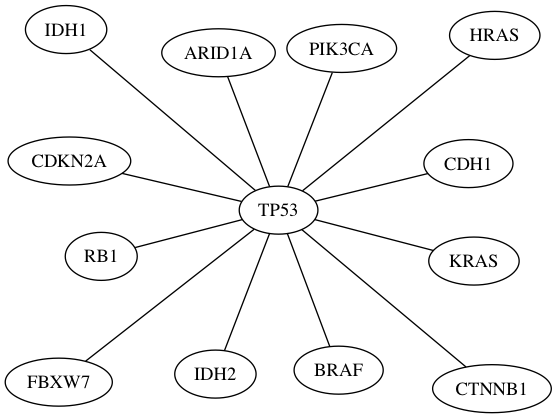

****
## Extend Graph by Walking over Nodes.

In [680]:
#1. enter a molecule.
#2. get w2v associated molecules.
#3. create parent:child relationships

#To do the above, it would be nice to have a good class representing a Molecule (with parent, child relationships)

import math

class Molecule:
    def __init__(self, name, parent=None):
        self.name = name
        self.children = []
        self.parent = parent
        self.generation = len(self._trace_lineage())
    
    def make_babies(self):
        #can only make babies once
        if self.children == []:
            new_children_names = model.most_similar(self.name, topn=math.floor(self.generation-5)**2-2)
            new_children_names = [x[0] for x in new_children_names]
            approved_names, _,_ = bin_approve_fail_notFound(new_children_names)
            #remove self when making kids
            if self.name in approved_names:
                approved_names.remove(self.name)
            #remove parent, if there is one, from kids
            if self.parent != None and self.parent in approved_names:
                approved_names.remove(self.name)    
            self.children = [Molecule(approved_name, parent=self) for approved_name in approved_names]
        return self.children
        
    def _trace_lineage(self):
        ancestry = []
        pointer = self.parent
        while pointer != None:
            ancestry.append(self.parent)
            if pointer == None: #this is the root of the graph, no parent
                break
            else:
                pointer = pointer.parent
        return ancestry
    
    def __str__(self):
        return f'<Molecule, parent:{self.parent}, gen:{self.generation}, children:{len(self.children)}>'
            
    def __repr__(self):
        return f'<Molecule, name:{self.name}, gen:{self.generation}, children:{len(self.children)}>'
    
        
    

In [727]:
def print_all(list_mols):
    for mol in list_mols:
        print(f'{mol.name:8} {mol.generation:3}')

def spawn_network(seeds):
    progeny=[]
    for seed in seeds:
        print(f'PARENT {seed.name}')
        progeny = seed.make_babies()
        #could draw update graph at this point
        print_all(progeny)
    return progeny


def create_network_from(mol_name):
    A = Molecule(mol_name, parent=None)
    gen = spawn_network([A])
    for i in range(7):
        gen = spawn_network(gen)
    return A

A = create_network_from('DICER1')


PARENT DICER1
TP63       1
MYO6       1
AXIN1      1
RASA1      1
NOTCH2     1
CTNNB1     1
HOXA1      1
WNT10A     1
CDKN2A     1
HOXB13     1
BAP1       1
DROSHA     1
WNT7A      1
SMAD4      1
SUFU       1
AXIN2      1
ARID1A     1
PPP2R1A    1
FBXW7      1
PARENT TP63
EYA1       2
NIPBL      2
DKC1       2
PAX6       2
STK11      2
WNT7A      2
HAX1       2
NOTCH2     2
SMARCB1    2
PARENT MYO6
RAPSN      2
PJVK       2
CLRN1      2
SH3TC2     2
FERMT3     2
TECTA      2
MYH14      2
PRPF31     2
POU4F3     2
EYA4       2
LAMA2      2
ACTG1      2
PARENT AXIN1
NOTCH2     2
TP63       2
AXIN2      2
TP53       2
SMAD4      2
SUFU       2
PTCH1      2
CTNNB1     2
CDKN2A     2
PARENT RASA1
EYA1       2
NIPBL      2
DKC1       2
TP63       2
FERMT3     2
NPHP4      2
STK11      2
IKBKG      2
NOTCH2     2
STXBP2     2
SPRED1     2
PARENT NOTCH2
SIX6       2
JAG1       2
PAX6       2
TP63       2
LEMD3      2
LMX1B      2
WNT10A     2
AXIN1      2
LHX1       2
DLL3       2
HAX1       2

In [728]:
def graph_the_network(starter):
    starter = [starter]
    import pygraphviz as pgv
    mol_graph = pgv.AGraph(strict=False, overlap=False, splines='spline')    
    
    def recursive_walk(nodes):
        for a_node in nodes:
            if a_node.parent != None:
                print(f'{a_node.parent.name} {a_node.parent.generation} -> {a_node.name} {a_node.generation}')
                mol_graph.add_edge(a_node.parent.name, a_node.name)
            else:
                print(f'{a_node.name} as ROOT')
            recursive_walk(a_node.children)
        
    recursive_walk(starter)

    mol_graph.graph_attr.update(size="30,30")
    mol_graph.layout()
    file_out='ancestry_DICER1_1.png'
    mol_graph.draw(file_out)      

graph_the_network(A)

DICER1 as ROOT
DICER1 0 -> TP63 1
TP63 1 -> EYA1 2
TP63 1 -> NIPBL 2
TP63 1 -> DKC1 2
TP63 1 -> PAX6 2
TP63 1 -> STK11 2
TP63 1 -> WNT7A 2
TP63 1 -> HAX1 2
TP63 1 -> NOTCH2 2
TP63 1 -> SMARCB1 2
DICER1 0 -> MYO6 1
MYO6 1 -> RAPSN 2
MYO6 1 -> PJVK 2
MYO6 1 -> CLRN1 2
MYO6 1 -> SH3TC2 2
MYO6 1 -> FERMT3 2
MYO6 1 -> TECTA 2
MYO6 1 -> MYH14 2
MYO6 1 -> PRPF31 2
MYO6 1 -> POU4F3 2
MYO6 1 -> EYA4 2
MYO6 1 -> LAMA2 2
MYO6 1 -> ACTG1 2
DICER1 0 -> AXIN1 1
AXIN1 1 -> NOTCH2 2
AXIN1 1 -> TP63 2
AXIN1 1 -> AXIN2 2
AXIN1 1 -> TP53 2
AXIN1 1 -> SMAD4 2
AXIN1 1 -> SUFU 2
AXIN1 1 -> PTCH1 2
AXIN1 1 -> CTNNB1 2
AXIN1 1 -> CDKN2A 2
DICER1 0 -> RASA1 1
RASA1 1 -> EYA1 2
RASA1 1 -> NIPBL 2
RASA1 1 -> DKC1 2
RASA1 1 -> TP63 2
RASA1 1 -> FERMT3 2
RASA1 1 -> NPHP4 2
RASA1 1 -> STK11 2
RASA1 1 -> IKBKG 2
RASA1 1 -> NOTCH2 2
RASA1 1 -> STXBP2 2
RASA1 1 -> SPRED1 2
DICER1 0 -> NOTCH2 1
NOTCH2 1 -> SIX6 2
NOTCH2 1 -> JAG1 2
NOTCH2 1 -> PAX6 2
NOTCH2 1 -> TP63 2
NOTCH2 1 -> LEMD3 2
NOTCH2 1 -> LMX1B 2
NOTCH2 1 -

In [733]:
!open ancestry_DICER1_1.png